# Prediction of quality of Wine

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

/Users/jahyeon_gu/.pyenv/versions/anaconda3-2022.05/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
wine = pd.read_csv("../data/winequality-red.csv")

# 데이터 살펴보기


In [9]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [10]:
# 모든 타입이 숫자 -> 바로 계산에 이용 가능
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [11]:
# 결측치가 없는 모습
wine.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

<AxesSubplot:xlabel='quality', ylabel='alcohol'>

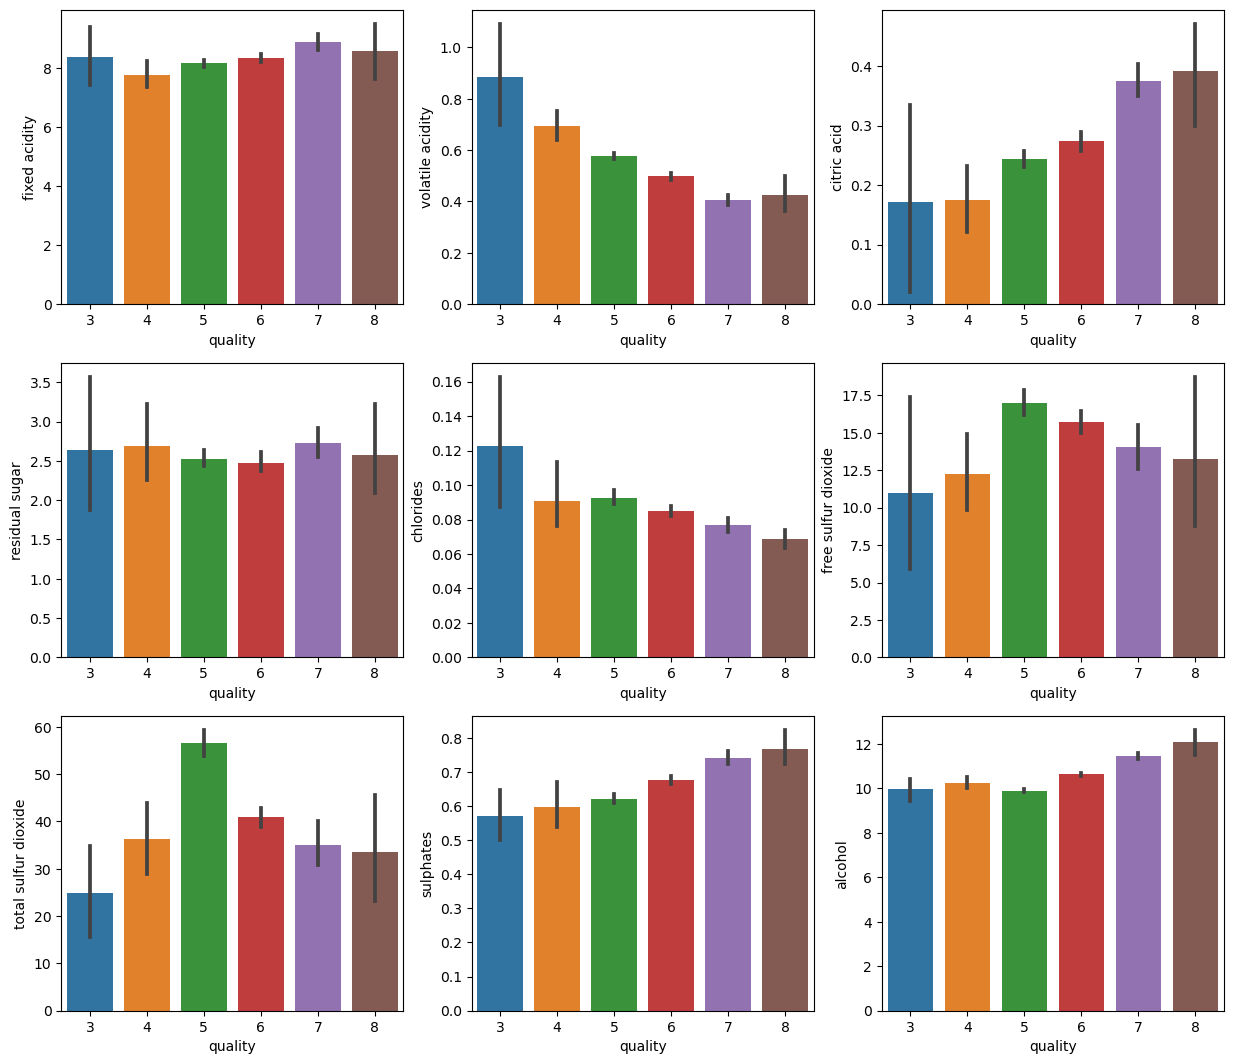

In [12]:
# 각 column 시각화
# quality에 따라 뚜렷한 차이를 보이는 column과 그렇지 않은 column 확인 가능
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 13))
sns.barplot(x='quality', y='fixed acidity', data=wine, ax=axes[0, 0])
sns.barplot(x='quality', y='volatile acidity', data=wine, ax=axes[0, 1])
sns.barplot(x='quality', y='citric acid', data=wine, ax=axes[0, 2])
sns.barplot(x='quality', y='residual sugar', data=wine, ax=axes[1, 0])
sns.barplot(x='quality', y='chlorides', data=wine, ax=axes[1, 1])
sns.barplot(x='quality', y='free sulfur dioxide', data=wine, ax=axes[1, 2])
sns.barplot(x='quality', y='total sulfur dioxide', data=wine, ax=axes[2, 0])
sns.barplot(x='quality', y='sulphates', data=wine, ax=axes[2, 1])
sns.barplot(x='quality', y='alcohol', data=wine, ax=axes[2, 2])

<AxesSubplot:>

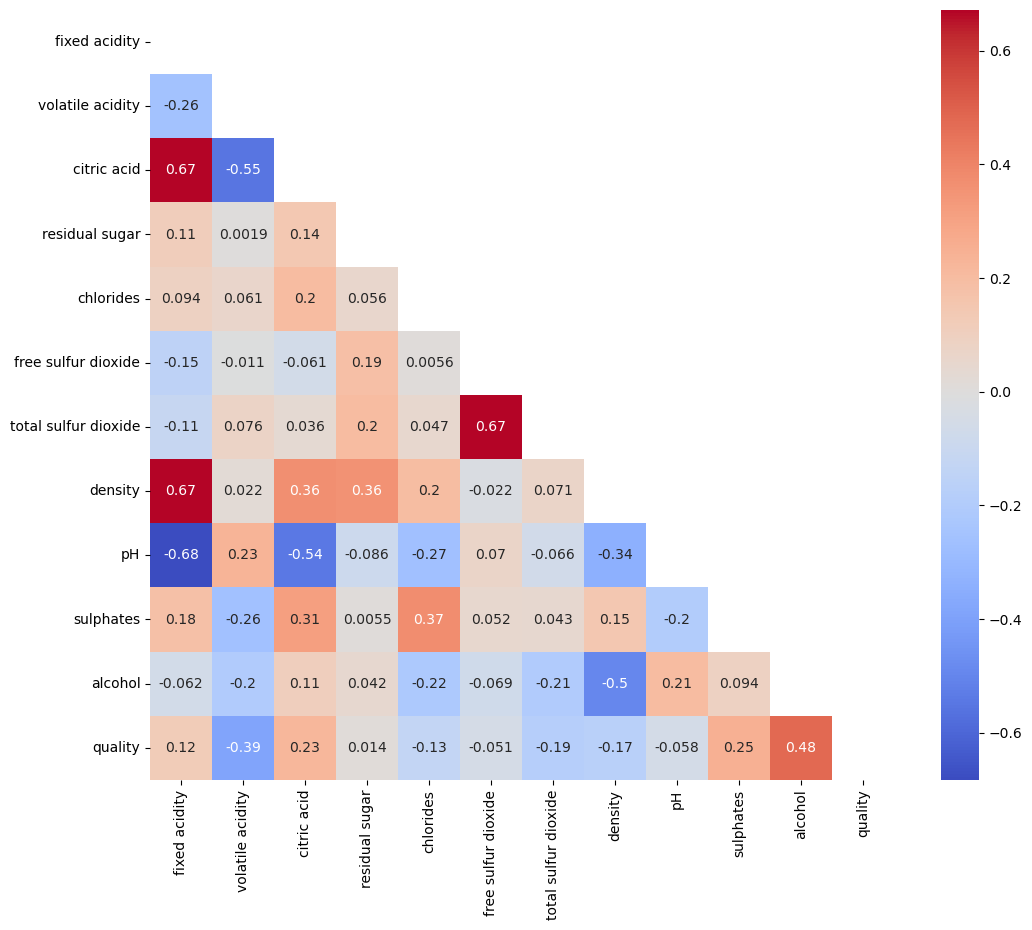

In [13]:
# quality에 영향을 미치는 정도를 상관계수, 히트맵을 이용하여 시각화
mask = np.triu(np.ones_like(wine.corr()))

plt.figure(figsize=(12, 10))
sns.heatmap(wine.corr(), mask=mask, cmap='coolwarm', annot=True)

# 데이터 전처리
* 연속형 데이터를 범주형 데이터로 변환하는 pd.cut()
* bins=(초과, 이하)

In [14]:
# 전처리 전 데이터 원본
wine.sample(10, random_state=14)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
667,11.3,0.340,0.45,2.0,0.082,6.0,15.0,0.99880,2.94,0.66,9.2,6
1082,7.2,0.380,0.30,1.8,0.073,31.0,70.0,0.99685,3.42,0.59,9.5,6
259,10.0,0.310,0.47,2.6,0.085,14.0,33.0,0.99965,3.36,0.80,10.5,7
176,7.3,0.380,0.21,2.0,0.080,7.0,35.0,0.99610,3.33,0.47,9.5,5
1417,7.3,0.340,0.33,2.5,0.064,21.0,37.0,0.99520,3.35,0.77,12.1,7
1212,6.8,0.650,0.02,2.1,0.078,8.0,15.0,0.99498,3.35,0.62,10.4,6
220,7.8,0.340,0.37,2.0,0.082,24.0,58.0,0.99640,3.34,0.59,9.4,6
1207,9.9,0.720,0.55,1.7,0.136,24.0,52.0,0.99752,3.35,0.94,10.0,5
105,8.1,0.575,0.22,2.1,0.077,12.0,65.0,0.99670,3.29,0.51,9.2,5
836,6.7,0.280,0.28,2.4,0.012,36.0,100.0,0.99064,3.26,0.39,11.7,7


In [15]:
# (초과, 이하)
bins = (2, 6.5, 8)
group_names = ['bad', 'good']
wine['quality'] = pd.cut(wine['quality'], bins=bins, labels=group_names)

In [16]:
wine['quality']

0       bad
1       bad
2       bad
3       bad
4       bad
       ... 
1594    bad
1595    bad
1596    bad
1597    bad
1598    bad
Name: quality, Length: 1599, dtype: category
Categories (2, object): ['bad' < 'good']

In [17]:
# 범주형 데이터로 전처리
wine.sample(10, random_state=14)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
667,11.3,0.340,0.45,2.0,0.082,6.0,15.0,0.99880,2.94,0.66,9.2,bad
1082,7.2,0.380,0.30,1.8,0.073,31.0,70.0,0.99685,3.42,0.59,9.5,bad
259,10.0,0.310,0.47,2.6,0.085,14.0,33.0,0.99965,3.36,0.80,10.5,good
176,7.3,0.380,0.21,2.0,0.080,7.0,35.0,0.99610,3.33,0.47,9.5,bad
1417,7.3,0.340,0.33,2.5,0.064,21.0,37.0,0.99520,3.35,0.77,12.1,good
1212,6.8,0.650,0.02,2.1,0.078,8.0,15.0,0.99498,3.35,0.62,10.4,bad
220,7.8,0.340,0.37,2.0,0.082,24.0,58.0,0.99640,3.34,0.59,9.4,bad
1207,9.9,0.720,0.55,1.7,0.136,24.0,52.0,0.99752,3.35,0.94,10.0,bad
105,8.1,0.575,0.22,2.1,0.077,12.0,65.0,0.99670,3.29,0.51,9.2,bad
836,6.7,0.280,0.28,2.4,0.012,36.0,100.0,0.99064,3.26,0.39,11.7,good


In [18]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   fixed acidity         1599 non-null   float64 
 1   volatile acidity      1599 non-null   float64 
 2   citric acid           1599 non-null   float64 
 3   residual sugar        1599 non-null   float64 
 4   chlorides             1599 non-null   float64 
 5   free sulfur dioxide   1599 non-null   float64 
 6   total sulfur dioxide  1599 non-null   float64 
 7   density               1599 non-null   float64 
 8   pH                    1599 non-null   float64 
 9   sulphates             1599 non-null   float64 
 10  alcohol               1599 non-null   float64 
 11  quality               1599 non-null   category
dtypes: category(1), float64(11)
memory usage: 139.2 KB


In [19]:
label_quality = LabelEncoder()

In [20]:
wine['quality'] = label_quality.fit_transform(wine['quality'])

In [21]:
# Categorical 데이터를 Numerical하게 변경
wine.sample(10, random_state=14)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
667,11.3,0.340,0.45,2.0,0.082,6.0,15.0,0.99880,2.94,0.66,9.2,0
1082,7.2,0.380,0.30,1.8,0.073,31.0,70.0,0.99685,3.42,0.59,9.5,0
259,10.0,0.310,0.47,2.6,0.085,14.0,33.0,0.99965,3.36,0.80,10.5,1
176,7.3,0.380,0.21,2.0,0.080,7.0,35.0,0.99610,3.33,0.47,9.5,0
1417,7.3,0.340,0.33,2.5,0.064,21.0,37.0,0.99520,3.35,0.77,12.1,1
1212,6.8,0.650,0.02,2.1,0.078,8.0,15.0,0.99498,3.35,0.62,10.4,0
220,7.8,0.340,0.37,2.0,0.082,24.0,58.0,0.99640,3.34,0.59,9.4,0
1207,9.9,0.720,0.55,1.7,0.136,24.0,52.0,0.99752,3.35,0.94,10.0,0
105,8.1,0.575,0.22,2.1,0.077,12.0,65.0,0.99670,3.29,0.51,9.2,0
836,6.7,0.280,0.28,2.4,0.012,36.0,100.0,0.99064,3.26,0.39,11.7,1


In [22]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [23]:
wine['quality'].value_counts()

0    1382
1     217
Name: quality, dtype: int64

In [24]:
X = wine.drop('quality', axis = 1)
y = wine['quality']

In [25]:
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [26]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: quality, dtype: int64

# train & test 

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
* 입력 변수의 크기를 조정
* 모델에 사용할 입력 변수들의 크기를 일정 범위 내로 조정
* 경사 하강법을 조금 더 빨리할 수 있다는 장점
* 평균은 0, 표준 편차는 1

In [28]:
sc = StandardScaler()

In [29]:
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# ML : RandonForestClassifier 

In [30]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [31]:
# accuracy는 높으나 재현율이 낮은 모습
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       273
           1       0.61      0.36      0.45        47

    accuracy                           0.87       320
   macro avg       0.75      0.66      0.69       320
weighted avg       0.85      0.87      0.86       320



In [32]:
(y_pred==y_test).mean()

0.871875

In [33]:
# confusion_matrix
# [[TN, FP],
#  [FN, TP]]

In [34]:
confusion_matrix(y_test, y_pred)

array([[262,  11],
       [ 30,  17]])

In [35]:
(265 + 19) / (265 + 8 + 28 + 19)

0.8875

# ML : SGDC, Stochastic Gradient Decent Classifier

In [36]:
sgd = SGDClassifier(penalty=None)
sgd.fit(X_train, y_train)
pred_sgd = sgd.predict(X_test)

In [37]:
print(classification_report(y_test, pred_sgd))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       273
           1       0.48      0.45      0.46        47

    accuracy                           0.85       320
   macro avg       0.69      0.68      0.69       320
weighted avg       0.84      0.85      0.84       320



In [38]:
confusion_matrix(y_test, pred_sgd)

array([[250,  23],
       [ 26,  21]])

# ML : SVC, Support Vector Classifier

In [39]:
svc = SVC()
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_test)

In [40]:
print(classification_report(y_test, pred_svc))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       273
           1       0.71      0.26      0.37        47

    accuracy                           0.88       320
   macro avg       0.80      0.62      0.65       320
weighted avg       0.86      0.88      0.85       320



# GridSearchCV

In [41]:
param = {
    'C': [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4],
    'kernel':['linear', 'rbf'],
    'gamma':[0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4]
}

grid_svc = GridSearchCV(svc, param_grid=param, scoring='accuracy', cv=10)

In [42]:
grid_svc.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4],
                         'gamma': [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [43]:
grid_svc.best_params_

{'C': 1.2, 'gamma': 0.9, 'kernel': 'rbf'}

In [44]:
svc2 = SVC(C=1.2, gamma=0.9, kernel='rbf')
svc2.fit(X_train, y_train)
pred_svc2 = svc2.predict(X_test)
print(classification_report(y_test, pred_svc2))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       273
           1       0.89      0.34      0.49        47

    accuracy                           0.90       320
   macro avg       0.89      0.67      0.72       320
weighted avg       0.90      0.90      0.88       320



# Cross Validation

In [45]:
rfc_eval = cross_val_score(estimator=rfc, X=X_train, y=y_train, cv=10)
rfc_eval.mean()

0.9140194389763779